# IJF Web Scraper - Technical Test

Michael Wing-Cheung Wong

## Overview

Python and module versions used:
- Python ver. 3.7.3
- numpy ver. 1.19.0
- pandas ver. 1.1.0
- seaborn ver. 0.10.1
- matplotlib ver. 3.2.2

# Module Calls

In [2]:
############### PYTHON 3



#Module Imports
import os
import platform
import matplotlib
import re
import json

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from typing import Iterable, List, Union
from bs4 import BeautifulSoup

%matplotlib inline


print("Python ver. "+platform.python_version())
print("numpy ver. "+np.__version__)
print("pandas ver. "+pd.__version__)
print("seaborn ver. "+sns.__version__)
print("matplotlib ver. "+matplotlib.__version__)

pd.set_option('display.max_colwidth', None)

Python ver. 3.8.3
numpy ver. 1.18.5
pandas ver. 1.0.5
seaborn ver. 0.11.1
matplotlib ver. 3.2.2


# Data Read-in and Cleaning

In [2]:
## Data Read-in, ignore unnecessary columns
data = pd.read_csv("Data/twitter_sentiment_data/training.1600000.processed.noemoticon.csv",encoding = "ISO-8859-1",usecols=[0,5],names=["Sentiment Score","Tweet"])
data.tail()

,Sentiment Score,Tweet
1599995,4,Just woke up. Having no school is the best feeling ever
1599996,4,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,4,Are you ready for your MoJo Makeover? Ask me for details
1599998,4,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur
1599999,4,happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H


       Sentiment Score
count  1.600000e+06   
mean   2.000000e+00   
std    2.000001e+00   
min    0.000000e+00   
25%    0.000000e+00   
50%    2.000000e+00   
75%    4.000000e+00   
max    4.000000e+00   
1600000


D:\Users\Michael\anaconda3\envs\ml_nlp\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


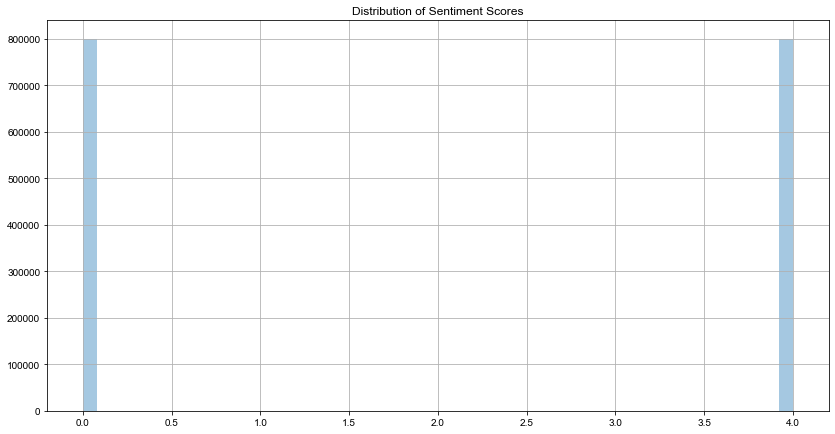

In [3]:
## Initial Data Visualization
print(data.describe())
print(len(data))
#print(data["Sentiment Score"].tolist())


fig, ax = plt.subplots(figsize=[14,7])
sentiment_histogram = sns.distplot(data["Sentiment Score"].tolist(), kde=False)#, height=7, aspect=0.9)
sns.set()
plt.subplots_adjust(top=0.9)
plt.title("Distribution of Sentiment Scores")
plt.grid()
#plt.savefig('figures\sns fig1.png') 

In [4]:
## Manually convert sentiment scores to positive/negative binary categories and move to target array

X = data.copy()
y = ["Positive" if sentiment == 4 else "Negative" for sentiment in X["Sentiment Score"]]

#Since sentiment can be considered to be ordinal, use label encoder
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

X = X.drop("Sentiment Score", axis=1)
display(X)
display(y)
print(le.classes_)
print(len(y))

,Tweet
0,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."
...,...
1599995,Just woke up. Having no school is the best feeling ever
1599996,TheWDB.com - Very cool to hear old Walt interviews! â« http://blip.fm/~8bmta
1599997,Are you ready for your MoJo Makeover? Ask me for details
1599998,Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur


array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

['Negative' 'Positive']
1600000


In [5]:
# Take only 10% of data for speed purposes
X, _, y, _ = train_test_split(X, y, test_size=0.9, random_state=42)
display(X)
display(y)

,Tweet
644091,God I'm sort of annoying its like great+ awful+fabulous at the same time! hahahahah shit
721723,"In VT, missing my hubby"
1057340,just got a present from apple
628980,@martinsays I want the new album â¥kinda of impossible
172036,"@LizzieGrubman have a great time in the Hamptons. Hope it's for some relaxation, not for work"
...,...
259178,this song's middle change just doesn't want to be born..... arghhhh!!
1414414,@officialnjonas Good luck with that
131932,@ProudGamerTweet I rather average 32370
671155,Pickin up @misstinayao waitin on @sadittysash 2 hurry up...I odeeee missed dem Table talk 2nite...LOL bout to be fat...


array([0, 0, 1, ..., 0, 0, 0], dtype=int64)

In [6]:
## Do preprocessing here since it is not dependent on data splitting

def tweet_cleaner(X):
    print("Preprocessing...")
    X["Tweet"] = [(BeautifulSoup(tweet,"lxml").get_text()) for tweet in X["Tweet"]]
    X["Tweet"] = [re.sub(r"@[A-Za-z0-9]+","",tweet) for tweet in X["Tweet"]]
    X["Tweet"] = [re.sub("https?://[A-Za-z0-9./]+","",tweet) for tweet in X["Tweet"]]
    X["Tweet"] = [re.sub("www.[A-Za-z0-9./]+","",tweet) for tweet in X["Tweet"]]
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X["Tweet"])
    X["Tweet"] = tokenizer.texts_to_sequences(X["Tweet"])
    X["Tweet"] = tokenizer.sequences_to_texts(X["Tweet"])
    print("Preprocess Complete")
    return X

def text_cleaner(X, remove_stopwords=False, stopwords=None, stem_words=False):

    # Clean the text, with the option to remove stopwords and to stem words.
    print("Preprocessing...")
    
    X_new = []
    # Convert words to lower case and split them
    for text in X["Tweet"]:
        text = text.lower().split()

        # Optionally, remove stop words
        if remove_stopwords:
            text = [w for w in text if not w in stopwords]

        text = " ".join(text)

        # Clean the text
        text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"that's", "that is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r",", " ", text)
        text = re.sub(r"\.", " ", text)
        text = re.sub(r"!", " ! ", text)
        text = re.sub(r"'", " ", text)
        text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
        text = re.sub(r":", " : ", text)
        text = re.sub(r" e g ", " eg ", text)
        text = re.sub(r" b g ", " bg ", text)
        text = re.sub(r" u s ", " american ", text)
        text = re.sub(r"\0s", "0", text)
        text = re.sub(r" 9 11 ", "911", text)
        text = re.sub(r"e - mail", "email", text)
        text = re.sub(r"\s{2,}", " ", text)

        # Optionally, shorten words to their stems
        if stem_words:
            text = text.split()
            stemmer = SnowballStemmer('english')
            stemmed_words = [stemmer.stem(word) for word in text]
            text = " ".join(stemmed_words)

        X_new.append(text)
    
    X["Tweet"] = np.array(X_new)
    
    print("Preprocess Complete")
    
    return X

In [7]:
X_new = tweet_cleaner(X)

Preprocessing...
Preprocess Complete


# Train-test Split

In [8]:
## Split data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.3, random_state=42)
#display(X_train)

display(X_train[:5])
display(X_test[:5])
display(y_train[:5])
display(len(y_test))
#display(y_valid)

,Tweet
510483,looks like tonight's a bit of a bust
1595178,you betcha jack wp is easy peasy stuff for me thinking some videos are in order
10758,twit help how do i remove twitter column from tweet deck i set it to stay signed in it's not budging and i dont want it there anymore
1258939,i have waited for the right opportunity to think about renting
61753,something good come on tv


,Tweet
178253,iphone is doing that not opening downloaded apps thing and i forgot my cord at home
1592775,day of the tentacle briljant
673189,who's that girl livin' my life i'm soooo sad why i love u but i want him
726641,tryna b a gud friend but i dunno if i can keep dis up ne longa
1161139,ciao teso come stai


array([0, 1, 0, 1, 0], dtype=int64)

48000

In [9]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_new, y, test_size=0.9, random_state=43)

# Supervised Learning

## Scikit Learn Pipeline Setup

In [10]:
# Function to fit a model pipeline
def pipeline_fit(X_train, y_train, pipeline, save_name, keras_nn=False, search_method=None,
                 n_iter=10, cv=5, verbose_searchcv=0, n_jobs=1):
    
    """
    Fits an sklearn machine learning pipeline
    
    Parameters
    ----------
    X_train : numpy array
        Training data 
        
    y_train : numpy array
        Training target data
        
    pipeline : string
        name of the sklearn pipeline to be fitted
            
    save_name : string
        name of saved joblib file
    
    keras_nn : boolean (default = False)
        set to True for Keras models
    
    search_method : string (default None)
        "randomsearch" for hyperparameter optimization using sklearn's RandomizedSearchCV
        "gridsearch" for hyperparameter optimization using sklearn's GridSearchCV
        None for no hyperparameter optimization
        
    n_iter : integer(default 10)
        number of parameter settings sampled, applies for randomsearch only
        
    cv : integer (default 5)
        number of cross validation folds for hyperparameter optimization
        
    verbose_searchcv : integer (default 0)
        set verbosity of search cv
        
    n_jobs : integer (default 1)
        number of jobs to run in parallel, -1 for all processors

    Returns
    -------
    sklearn fitted model object
    
    """
    
    while os.path.exists("{}_{}.joblib".format(save_name,pipeline)):
        # Check if a joblib file with that filename already exists, ask user for confirmation of overwrite
        skip = input('''A joblib model file already exists with that name, 
do you wish to retrain the model? (Y/N)''')
        if skip.lower().strip() == "y":
            break
        elif skip.lower().strip() == "n":
            print("Loaded pre-existing model:")
            print("Param Grid:", pipe_dict[pipeline][1])
            
            model_final = joblib.load("{}_{}.joblib".format(save_name,pipeline))
            
            # Load keras model and append to pipeline
            if keras_nn == True:
                model_final.named_steps["keras_estimator"].model = load_model("{}_{}.h5".format(save_name,pipeline))
                

            print("Parameters: ", model_final.get_params)

            return model_final

        else:
            print("That's not a valid response. Please try again.")
            
    
    # Do hyperparameter optimization
    
    # Keras hyperparameter search only works with a single process
    if keras_nn == True:
        n_jobs = 1
    else:
        pass

    if search_method == "randomsearch":
        search_cv = RandomizedSearchCV(pipe_dict[pipeline][0], param_distributions=pipe_dict[pipeline][1], n_iter=n_iter,
                                       cv=cv, verbose=verbose_searchcv, n_jobs=n_jobs)
    elif search_method == "gridsearch":
        search_cv = GridSearchCV(pipe_dict[pipeline][0], param_grid=pipe_dict[pipeline][1],
                                 cv=cv, verbose=verbose_searchcv, n_jobs=n_jobs)
    elif search_method == None:
        
        # No optimization is performed, fit to model only
        print("No hyperparameter optimization")
        print("Training {} on {} samples...".format(pipeline,str(len(y_train))))
        print(pipe_dict[pipeline][0].steps[-1])
        model_final = pipe_dict[pipeline][0].fit(X_train, y_train)

        # For Keras neural networks, save the sklearn pipeline and Keras model separately
        # Use joblib to dump the best estimator to joblib file for persistence purposes
        if keras_nn == True:
            # print(model_final.named_steps["keras_estimator"].model.summary())            

            # Save Keras model and remove it from pipeline
            model_final.named_steps["keras_estimator"].model.save("{}_{}.h5".format(save_name,pipeline))
            model_final.named_steps["keras_estimator"].model = None

            # Save pipeline
            joblib.dump(model_final, save_name+"_"+pipeline+".joblib")

            # Rebuild pipeline to return
            model_final.named_steps["keras_estimator"].model = load_model("{}_{}.h5".format(save_name,pipeline))

            return model_final

        # Save the pipeline
        joblib.dump(model_final, "{}_{}.joblib".format(save_name,pipeline))

        return model_final

    print(pipe_dict[pipeline][0])
    print("Param Grid:", pipe_dict[pipeline][1])
    
    # Train the model
    print()
    print("Training {} on {} samples...".format(pipeline,str(len(y_train))))
    print("Shape of inputs:",X_train.shape)
    print(X_train[:5])
    print("Shape of outputs:",y_train.shape)
    print(y_train[:5])
    print()
#     try:
    search_cv.fit(X_train, y_train)
#     except ValueError:
#         ## If X_train is a dataframe with single column, convert y_train to match
#         search_cv.fit(X_train, y_train.reshape(-1,1))
        
    print("")
    print(pipeline+":")
    print("Best Score: ", search_cv.best_score_)
    print("Best Params: ", search_cv.best_params_)

    model_final = search_cv.best_estimator_
    
    # Use joblib to dump the best estimator to joblib file for persistence purposes
    # For Keras neural networks, save the sklearn pipeline and Keras model separately
    if keras_nn == True:
        # print(model_final.named_steps["keras_estimator"].model.summary())
        
        # Save Keras model and remove it from pipeline
        model_final.named_steps["keras_estimator"].model.save("{}_{}.h5".format(save_name,pipeline))
        model_final.named_steps["keras_estimator"].model = None
        
        # Save pipeline
        joblib.dump(model_final, save_name+"_"+pipeline+".joblib")
        
        # Rebuild pipeline to return
        model_final.named_steps["keras_estimator"].model = load_model("{}_{}.h5".format(save_name,pipeline))
        
        return model_final

    else:
        # Save the pipeline
        joblib.dump(model_final, "{}_{}.joblib".format(save_name,pipeline))

    return model_final

In [11]:
## Initiate a full preprocessing and prediction pipeline

# ## RandomizedSearchCV hyperparameter optimization
# nb_param_grid = {
#     "nb_classifier__alpha": [1,1e-1,1e-2,0]
#     }

# svm_param_grid = {
#     "svm_classifier__C": [x for x in np.logspace(-5,15,base=2,num=7)],
#     "svm_classifier__gamma": gamma
#     }

# lstm_param_grid = {
#     "lstm_classifier__embed_dim": [128],
#     "lstm_classifier__lstm_out": [200],
#     #"lstm_classifier__dropout": [0.2],
#     #"lstm_classifier__dropout_U": [0.2],
#     #"lstm_classifier__dropout_W": [0.2],
#     "lstm_classifier__epochs": [50, 100, 150],
#     "lstm_classifier__batch_size": [5, 10, 20]
#     }

In [12]:
# param_grid = {
#     #"preprocessor__tweet_transformer__tfidf_vectorizer__max_df": np.linspace(0.2, 1, 10),
#     "preprocessor__tweet_transformer__tfidf_vectorizer__binary": [True],
#     "preprocessor__tweet_transformer__tfidf_vectorizer__token_pattern": [r"(?u)\b\w\w+\b|\'"],
#     "preprocessor__tweet_transformer__tfidf_vectorizer__ngram_range": [(1,2)],
#     "preprocessor__tweet_transformer__tfidf_vectorizer__sop_": [(1,2)]
#     }

# nb_param_grid.update(param_grid)
# rf_param_grid.update(param_grid)
# gb_param_grid.update(param_grid)
# lgbm_param_grid.update(param_grid)
# xgb_param_grid.update(param_grid)
# svm_param_grid.update(param_grid)
# lstm_param_grid.update(param_grid)

In [13]:
# # Dictionary of pipelines and classifier types for ease of reference
# pipe_dict = {
#             "MultinomialNB" : (nb_clf_fullpipe, nb_param_grid),
#             "RandomForest" : (rf_clf_fullpipe, rf_param_grid),
#             "GradientBoosting" : (gb_clf_fullpipe, gb_param_grid),
#             "XGBoost" : (xgb_clf_fullpipe, xgb_param_grid),
#             "LightGBM" : (lgbm_clf_fullpipe, lgbm_param_grid),
#             "SVC" : (svm_clf_fullpipe, svm_param_grid),
#             "LSTM" : (LSTM_clf_fullpipe, lstm_param_grid)
#             }

In [14]:
# lstm_clf_final = pipeline_fit(pipeline="LSTM", cv=5, iid=False, verbose=2, n_jobs=1, optimization=True)

# Training, Predictions and Evaluation Metrics

## Plotting Functions

In [15]:
def plot_confusion_matrix(y_test, y_pred, classes, figsize=(8,8), save_name=None, cmap=plt.cm.Blues):
    
    """
    Plots a confusion matrix
    
    Parameters
    ----------
    y_test : numpy array
        Ground truth target values 
        
    y_pred : numpy array
        Predicted target values
        
    classes : numpy array
        class names 
        
    figsize : tuple (default = (8,8))
        a tuple for matplotlib figsize (x,y)    
        
    save_name : string (default = None)
        name of the plot to be saved, including the file extension
        None for no plot saving
        
    cmap : matplotlib colour map (default = Blue)

    Returns
    -------
    None
    
    """

    cm = confusion_matrix(y_test, y_pred)
    classes = classes[unique_labels(y_test, y_pred)]
    # Get normalized confusion matrix
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

#     print("Confusion Matrix")
#     print(cm)
#     print("Normalized Confusion Matrix")
#     print(cm_norm)

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(None)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel="True Labels", xlabel="Predicted Labels")

    # Loop over data dimensions and create text annotations
    # using both normalized and non-normalized confusion matrices
    def annotated_text(i, j):
        return str(cm[i, j])+"\n("+str(format(cm_norm[i, j], ".2f"))+")"

    # Text color switches to provide contrast
    col_switch_thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, annotated_text(i, j),
                    ha="center", va="center",
                    color="white" if cm[i, j] > col_switch_thresh else "black")
    fig.tight_layout()
    
    if save_name is not None:
        fig = ax.get_figure()
        fig.savefig(save_name,bbox_inches="tight",pad_inches=0.2) 

In [16]:
def plot_roc_curve(y_test, y_score, classes, roc_multilabel_count=3, figsize=(8,8), save_name=None):
    
    """
    Plots ROC curves for classification scores
    
    Parameters
    ----------
    
    y_test : numpy array
        Ground truth target values 
        
    y_score : numpy array
        Predicted probabilities or decision functions of model of test set
        
    classes : numpy array
        class names 
        
    roc_multilabel_count : integer (default = 3)
        how many labels in a multilabel problem to plot
        
    figsize : tuple (default = (8,8))
        a tuple for matplotlib figsize (x,y)    
        
    save_name : string (default = None)
        name of the plot to be saved, including the file extension
        None for no plot saving

    Returns
    -------
    None
    
    """

    # Compute ROC curve and ROC area for each class
    fpr, tpr, roc_auc = {}, {}, {}
    n_classes = len(classes)
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
#         print(roc_auc)
        
        # Plot average and individual class curves
        fig, ax = plt.subplots(figsize=figsize)
        
        ax.plot(fpr, tpr, color=plt.cm.tab10(0), lw=2,
                     label="ROC curve (area = {0:0.4f})".format(roc_auc))
        
        # Plot 50% line
        ax.plot([0, 1], [0, 1], "k--", lw=2)
        ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05],
               ylabel="True Positive Rate", xlabel="False Positive Rate")
        ax.legend(loc="lower right")


    else:
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve([sublist[i] for sublist in y_test], 
                              [sublist[i] for sublist in y_score])
            roc_auc[i] = auc(fpr[i], tpr[i])

        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Interpolate ROC curves
        mean_tpr, all_tpr = np.zeros_like(all_fpr), 0
        for i in range(n_classes):
            all_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Average ROCs and compute AUC
        mean_tpr = all_tpr/n_classes

        fpr["avg"] = all_fpr
        tpr["avg"] = mean_tpr
        roc_auc["avg"] = auc(fpr["avg"], tpr["avg"])


        # Plot average and individual class curves
        fig, ax = plt.subplots(figsize=figsize)

        if roc_multilabel_count > 1:
            ax.plot(fpr["avg"], tpr["avg"],
                     label="Average ROC curve (area = {0:0.4f})".format(roc_auc["avg"]),
                     color="navy", linestyle=":", linewidth=4)

        for i in range(roc_multilabel_count):
            ax.plot(fpr[i], tpr[i], color=plt.cm.tab10(i), lw=2,
                     label="ROC curve of class {0} (area = {1:0.4f})".format(classes[i], roc_auc[i]))

        # Plot 50% line
        ax.plot([0, 1], [0, 1], "k--", lw=2)
        ax.set(xlim=[0.0, 1.0], ylim=[0.0, 1.05],
               ylabel="True Positive Rate", xlabel="False Positive Rate")
        ax.legend(loc="lower right")
    
    
    if save_name is not None:
        fig = ax.get_figure()
        fig.savefig(save_name,bbox_inches="tight",pad_inches=0.2) 

## Preprocessing

### Custom transforms and preprocessing pipeline steps

In [17]:
## Numeric features if applicable
#numeric_features = ['age', 'fare']
#numeric_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='median')),
#    ('scaler', StandardScaler())])

## Categorical features if applicable
#categorical_features = ["Sentiment Score"]
#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#preprocessor = ColumnTransformer(
#    transformers=[
#        ('num', numeric_transformer, numeric_features),
#        ("cat", categorical_transformer, categorical_features)])


## Create preprocessing pipelines


## Column selector (removes non-essential columns as defined by user), X must be a pandas dataframe
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

## Create custom transformer
class Tweet_cleaner(BaseEstimator, TransformerMixin):
    def __init__(self, verbose=False, word2vec=False):
        self.word2vec = word2vec
        self.verbose = verbose
        
    def fit(self, X, y=None):
        if(self.verbose):
            print("Verbose mode on!")
        return self
    
    def transform(self, X, y=None):
        #display(X)
        #Use beautifulsoup to decode HTML code
        print("Preprocessing...")
        X = [tweet for tweet in X["Tweet"]]
#         X = [(BeautifulSoup(tweet,"lxml").get_text()) for tweet in X["Tweet"]]
#         #X_2 = [re.sub(r"@[A-Za-z0-9]+","",tweet) for tweet in X_1]
#         X = [re.sub("https?://[A-Za-z0-9./]+","",tweet) for tweet in X]
#         X = [re.sub("www.[A-Za-z0-9./]+","",tweet) for tweet in X]
        
#         if self.word2vec:
#             # Concatenate to single string for word2vec embeddings transformation
#             X = " ".join(X)
            
        #X_5 = [(tweet.decode("utf-8-sig")).replace(u"\ufffd","") for tweet in X_4]
        #X_5 = [re.sub("[^a-zA-Z]"," ", tweet) for tweet in X_4]
        #display(X_4)
        print("Preprocess Complete")

        return X
    
class Text_cleaner(BaseEstimator, TransformerMixin):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    def __init__(self, verbose=False, remove_stopwords=False, stem_words=False, text_col=None, stopwords=None):
        self.verbose = verbose
        self.remove_stopwords = remove_stopwords
        self.stem_words = stem_words
        self.text_col = text_col
        self.stopwords = stopwords
        
    def fit(self, X, y=None):
        if(self.verbose):
            print("Verbose mode on!")
        return self
                 
    def transform(self, X, y=None):
        print("Preprocessing...")
        X_new = []
                 
        # Convert words to lower case and split them
        for text in X[self.text_col]:
            text = text.lower().split()

            # Optionally, remove stop words
            if self.remove_stopwords:
                text = [w for w in text if not w in self.stopwords]

            text = " ".join(text)

            # Clean the text
            text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
            text = re.sub(r"what's", "what is ", text)
            text = re.sub(r"that's", "that is ", text)
            text = re.sub(r"\'s", " ", text)
            text = re.sub(r"\'ve", " have ", text)
            text = re.sub(r"can't", "cannot ", text)
            text = re.sub(r"n't", " not ", text)
            text = re.sub(r"i'm", "i am ", text)
            text = re.sub(r"\'re", " are ", text)
            text = re.sub(r"\'d", " would ", text)
            text = re.sub(r"\'ll", " will ", text)
            text = re.sub(r",", " ", text)
            text = re.sub(r"\.", " ", text)
            text = re.sub(r"!", " ! ", text)
            text = re.sub(r"'", " ", text)
            text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
            text = re.sub(r":", " : ", text)
            text = re.sub(r" e g ", " eg ", text)
            text = re.sub(r" b g ", " bg ", text)
            text = re.sub(r" u s ", " american ", text)
            text = re.sub(r"\0s", "0", text)
            text = re.sub(r" 9 11 ", "911", text)
            text = re.sub(r"e - mail", "email", text)
            text = re.sub(r"\s{2,}", " ", text)

            # Optionally, shorten words to their stems
            if self.stem_words:
                text = text.split()
                stemmer = SnowballStemmer('english')
                stemmed_words = [stemmer.stem(word) for word in text]
                text = " ".join(stemmed_words)
            
            X_new.append(text)
    

        print("Preprocess Complete")

        return X_new
    
    
## Add debug step to retrieve shape 
class Debug(BaseEstimator, TransformerMixin):
    
    def __init__(self, verbose=False):
        self.verbose = verbose

    def fit(self, X, y=None):
        if(self.verbose):
            print("Verbose mode on!")
        return self
    
    def transform(self, X):
#         print(X[:5])
        self.shape = X.shape
        print(X.shape)
        # what other output you want
        return X

## Define preprocessor param grid

In [18]:
tweet_col = ["Tweet"]
tweet_transformer = Pipeline(steps=[
    ("cleaner", Tweet_cleaner()),
    ("tfidf_vectorizer", TfidfVectorizer()),
    ("debug", Debug())
    ])
  
preprocessor = ColumnTransformer(
    transformers=[
        ("tweet_transformer", tweet_transformer, tweet_col)
        ])

param_grid = {
    "preprocessor__tweet_transformer__tfidf_vectorizer__max_features": (1000,5000,15000),
    "preprocessor__tweet_transformer__tfidf_vectorizer__binary": [True],
    "preprocessor__tweet_transformer__tfidf_vectorizer__token_pattern": [r"(?u)\b\w\w+\b|\'"],
    "preprocessor__tweet_transformer__tfidf_vectorizer__ngram_range": [(1,2)],
    }

# Support Vector Machines

## Linear Support Vector Classifier

In [15]:
# Linear support Vector Classification using one-vs-rest classification for multiclass learning
linear_svc_clf = LinearSVC(verbose=0, multi_class="ovr", dual=False)
linear_svc_clf_fullpipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("linear_svc_classifier", linear_svc_clf)
])
print(linear_svc_clf_fullpipe)
print("")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tweet_transformer',
                                                  Pipeline(steps=[('cleaner',
                                                                   Tweet_cleaner()),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer()),
                                                                  ('debug',
                                                                   Debug())]),
                                                  ['Tweet'])])),
                ('linear_svc_classifier', LinearSVC(dual=False))])



In [138]:
# Specify hyperparameter grids for optimization

linear_svc_param_grid = {
    "linear_svc_classifier__penalty": ["l1","l2"],
    "linear_svc_classifier__C": [x for x in np.logspace(-5, 5, base=2, num=5)],
}

linear_svc_param_grid.update(param_grid)

In [139]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {
    "Linear_SVC": (linear_svc_clf_fullpipe, linear_svc_param_grid),
}

### Train the linear SVC pipeline model

In [140]:
linear_svc_clf_final = pipeline_fit(
                                        X_train=X_train,
                                        y_train=y_train,
                                        pipeline="Linear_SVC", 
                                        search_method="gridsearch", 
#                                         n_iter=3,
                                        verbose_searchcv=2, 
                                        n_jobs=12, 
                                        save_name="Twitter_test"
                                    )

A joblib model file already exists with that name, 
do you wish to retrain the model? (Y/N) y


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tweet_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('cleaner',
                                                                   Tweet_cleaner(verbose=False,
                                                                                 word2vec=False)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                             

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:   19.5s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:  1.8min finished


Preprocessing...
Preprocess Complete
(112000, 15000)

Linear_SVC:
Best Score:  0.7933214285714286
Best Params:  {'linear_svc_classifier__C': 0.1767766952966369, 'linear_svc_classifier__penalty': 'l2', 'preprocessor__tweet_transformer__tfidf_vectorizer__binary': True, 'preprocessor__tweet_transformer__tfidf_vectorizer__max_features': 15000, 'preprocessor__tweet_transformer__tfidf_vectorizer__ngram_range': (1, 2), 'preprocessor__tweet_transformer__tfidf_vectorizer__token_pattern': "(?u)\\b\\w\\w+\\b|\\'"}


### Evaluation

In [141]:
y_pred_linear_svc = linear_svc_clf_final.predict(X_test)
y_score_linear_svc = linear_svc_clf_final.decision_function(X_test)

Preprocessing...
Preprocess Complete
(48000, 15000)
Preprocessing...
Preprocess Complete
(48000, 15000)


Accuracy Score on Test Set:
0.7941875


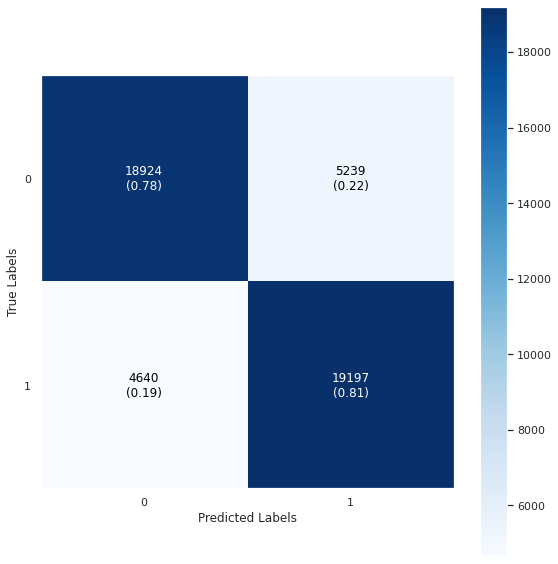

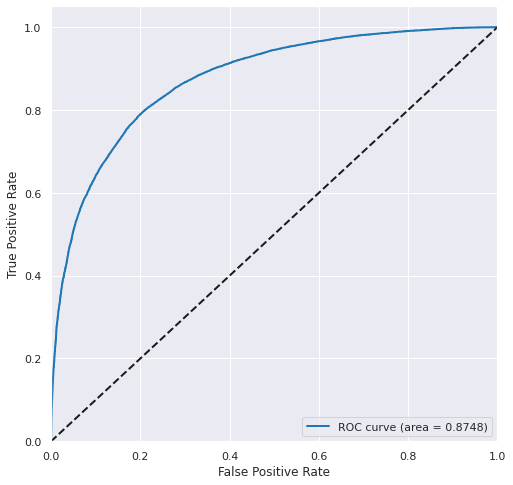

In [142]:
print("Accuracy Score on Test Set:")
# Inverse transform onehot labels using labelbinarizer
print(accuracy_score(y_test, y_pred_linear_svc))

# np.set_printoptions(precision=2)
# print(linear_svc_clf_final.classes_)
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_linear_svc, classes=linear_svc_clf_final.classes_)

# Plot ROC curve (requires onehot targets)
plot_roc_curve(y_test, y_score_linear_svc, classes=linear_svc_clf_final.classes_, roc_multilabel_count=2)

## Nonlinear Support Vector Classifier

In [143]:
# Specify hyperparameter grids for optimization

gamma = [x for x in np.logspace(-15, 3, base=2, num=7)]
gamma.append("scale")
gamma.append("auto")

svc_param_grid = {
    "svc_classifier__kernel": ["rbf"],#,"poly","sigmoid"],
#     "svc_classifier__degree": [3,4,5],
    "svc_classifier__C": [x for x in np.logspace(-5, 10, base=2, num=5)],
    "svc_classifier__gamma": gamma
}

svc_param_grid.update(param_grid)

In [144]:
# Nonlinear support Vector Classification using one-vs-one classification for multiclass learning
svc_clf = SVC(verbose=3)
svc_clf_fullpipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("svc_classifier", svc_clf)
])
print(svc_clf_fullpipe)
print("")

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tweet_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('cleaner',
                                                                   Tweet_cleaner(verbose=False,
                                                                                 word2vec=False)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                             

In [145]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict["SVC"] = (svc_clf_fullpipe, svc_param_grid)

### Train the Nonlinear SVC pipeline model

In [146]:
svc_clf_final = pipeline_fit(
                                X_train=X_train,
                                y_train=y_train,
                                pipeline="SVC", 
                                search_method="randomsearch", 
                                n_iter=3,
                                cv=3,
                                verbose_searchcv=2, 
                                n_jobs=-1, 
                                save_name=None
                            )

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tweet_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('cleaner',
                                                                   Tweet_cleaner(verbose=False,
                                                                                 word2vec=False)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                             

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   9 | elapsed:   48.6s remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   7 out of   9 | elapsed:   48.6s remaining:   13.9s


KeyboardInterrupt: 

### Evaluation

In [ ]:
y_pred_svc = svc_clf_final.predict(X_test)
y_score_svc = svc_clf_final.decision_function(X_test)

In [ ]:
print("Accuracy Score on Test Set:")
print(accuracy_score(y_test, y_pred_svc))

# np.set_printoptions(precision=2)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_svc, classes=svc_clf_final.classes_)

# Plot ROC curve (requires onehot targets)
plot_roc_curve(y_test_onehot, y_score_svc, classes=svc_clf_final.classes_, roc_multilabel_count=2)

# Random Forest Classifier

In [19]:
# Linear support Vector Classification using one-vs-rest classification for multiclass learning
rf_clf = RandomForestClassifier(verbose=0)
rf_clf_fullpipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rf_classifier", rf_clf)
])
print(rf_clf_fullpipe)
print("")

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tweet_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('cleaner',
                                                                   Tweet_cleaner(verbose=False,
                                                                                 word2vec=False)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                             

In [20]:
# Specify hyperparameter grids for optimization

max_depth = [int(x) for x in np.linspace(10,110,11)]
max_depth.append(None)

gamma = [x for x in np.logspace(-15,3,base=2,num=7)]
gamma.append("scale")
gamma.append("auto")

rf_param_grid = {
    "rf_classifier__n_estimators": [int(x) for x in np.linspace(50,500,11)],
    "rf_classifier__max_depth": max_depth,
    "rf_classifier__max_features": ["auto"],
    "rf_classifier__min_samples_split": [2, 10, 100],
    "rf_classifier__min_samples_leaf": [1, 2, 4, 10],
    }


rf_param_grid.update(param_grid)

In [21]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {
    "RandomForest": (rf_clf_fullpipe, rf_param_grid),
}

### Train the random forest pipeline model

In [22]:
print(X_train)
print(y_train)

                                                                                                                                         Tweet
510483   looks like tonight's a bit of a bust                                                                                                 
1595178  you betcha jack wp is easy peasy stuff for me thinking some videos are in order                                                      
10758    twit help how do i remove twitter column from tweet deck i set it to stay signed in it's not budging and i dont want it there anymore
1258939  i have waited for the right opportunity to think about renting                                                                       
61753    something good come on tv                                                                                                            
...                            ...                                                                                                            

In [23]:
rf_clf_final = pipeline_fit(
                                X_train=X_train,
                                y_train=y_train,
                                pipeline="RandomForest", 
                                search_method="randomsearch", 
                                n_iter=10,
                                verbose_searchcv=2, 
                                n_jobs=6, 
                                save_name="Twitter_test"
                            )

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tweet_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('cleaner',
                                                                   Tweet_cleaner(verbose=False,
                                                                                 word2vec=False)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                             

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
exception calling callback for <Future at 0x7fa1b53dc250 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/ataralyxius/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 404, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/ataralyxius/anaconda3/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/home/ataralyxius/anaconda3/lib/python3.8/site-packages/ipykernel/__init__.py", line 2, in <module>
    from .connect import *
  File "/home/ataralyxius/anaconda3/lib/python3.8/site-packages/ipykernel/connect.py", line 13, in <module>
    from IPython.core.profiledir import ProfileDir
  File "/home/ataralyxius/anaconda3/lib/python3.8/site-packages/IPython/__init__.py", line 56, in <module>

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

### Evaluation

In [ ]:
y_pred_linear_svc = rf_clf_final.predict(X_test)
y_score_linear_svc = rf_clf_final.decision_function(X_test)

Accuracy Score on Test Set:
0.7941875


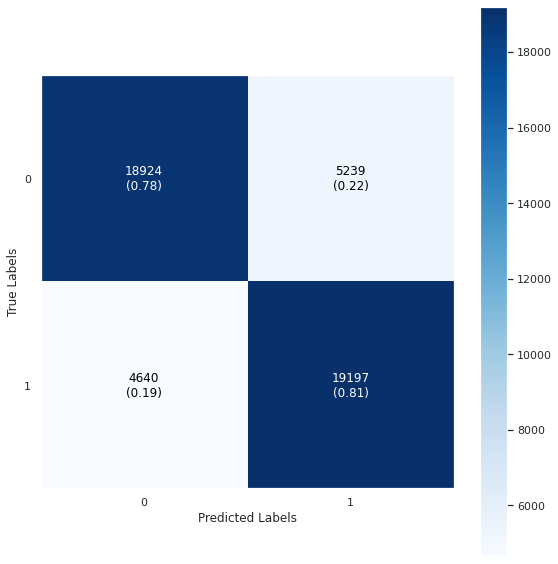

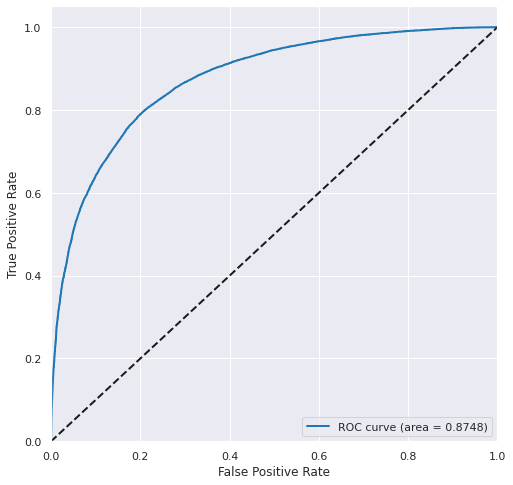

In [142]:
print("Accuracy Score on Test Set:")
# Inverse transform onehot labels using labelbinarizer
print(accuracy_score(y_test, y_pred_linear_svc))

# np.set_printoptions(precision=2)
# print(linear_svc_clf_final.classes_)
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_linear_svc, classes=rf_clf_final.classes_)

# Plot ROC curve (requires onehot targets)
plot_roc_curve(y_test, y_score_linear_svc, classes=rf_clf_final.classes_, roc_multilabel_count=2)

# Gradient Boosting Classifiers

## Sklearn Gradient Boosting

In [26]:
# Linear support Vector Classification using one-vs-rest classification for multiclass learning
gb_clf = GradientBoostingClassifier(verbose=0)
gb_clf_fullpipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("gb_classifier", gb_clf)
])
print(gb_clf_fullpipe)
print("")

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tweet_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('cleaner',
                                                                   Tweet_cleaner(verbose=False,
                                                                                 word2vec=False)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                             

In [27]:
# Specify hyperparameter grids for optimization

gb_param_grid = {
    "gb_classifier__n_estimators": [int(x) for x in np.linspace(50,500,11)],
    "gb_classifier__max_depth": max_depth
    }

gb_param_grid.update(param_grid)

In [28]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {
    "GradientBoost": (gb_clf_fullpipe, gb_param_grid),
}

### Train the gradient boosting pipeline model

In [29]:
gb_clf_final = pipeline_fit(
                                X_train=X_train,
                                y_train=y_train,
                                pipeline="GradientBoost", 
                                search_method="gridsearch", 
#                                         n_iter=3,
                                verbose_searchcv=2, 
                                n_jobs=12, 
                                save_name="Twitter_test"
                            )

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tweet_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('cleaner',
                                                                   Tweet_cleaner(verbose=False,
                                                                                 word2vec=False)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                             

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

### Evaluation

In [141]:
y_pred_linear_svc = gb_clf_final.predict(X_test)
y_score_linear_svc = gb_clf_final.decision_function(X_test)

Preprocessing...
Preprocess Complete
(48000, 15000)
Preprocessing...
Preprocess Complete
(48000, 15000)


Accuracy Score on Test Set:
0.7941875


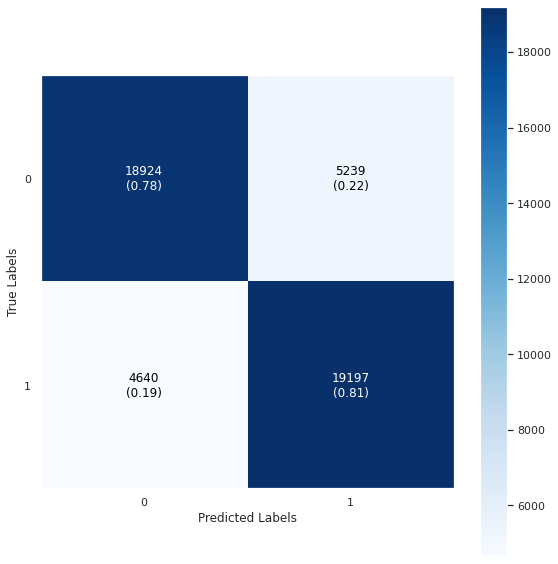

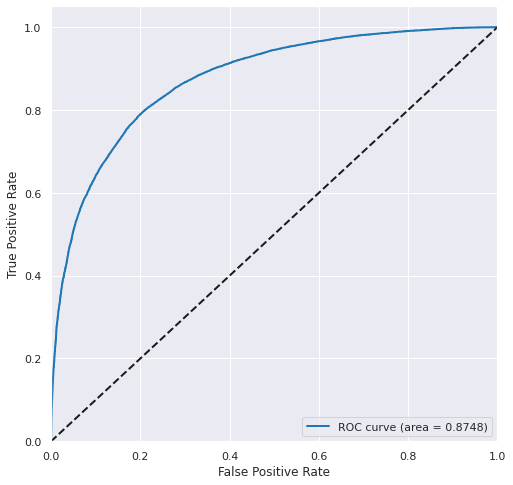

In [142]:
print("Accuracy Score on Test Set:")
# Inverse transform onehot labels using labelbinarizer
print(accuracy_score(y_test, y_pred_linear_svc))

# np.set_printoptions(precision=2)
# print(linear_svc_clf_final.classes_)
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_linear_svc, classes=gb_clf_final.classes_)

# Plot ROC curve (requires onehot targets)
plot_roc_curve(y_test, y_score_linear_svc, classes=gb_clf_final.classes_, roc_multilabel_count=2)

## XGBoost Classifier

In [1]:
# Linear support Vector Classification using one-vs-rest classification for multiclass learning
xgb_clf = XGBClassifier()
xgb_clf_fullpipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgb_classifier", xgb_clf)
])
print(xgb_clf_fullpipe)
print("")

NameError: name 'RandomForestClassifier' is not defined

In [138]:
# Specify hyperparameter grids for optimization

xgb_param_grid = {
    "xgb_classifier__n_estimators": [int(x) for x in np.linspace(50,550,11)],
    "xgb_classifier__max_depth": max_depth,  
    }

xgb_param_grid.update(param_grid)

In [139]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {
    "GradientBoost": (xgb_clf_fullpipe, xgb_param_grid),
}

### Train the gradient boosting pipeline model

In [140]:
xgb_clf_final = pipeline_fit(
                                X_train=X_train,
                                y_train=y_train,
                                pipeline="XGBoost", 
                                search_method="gridsearch", 
#                                         n_iter=3,
                                verbose_searchcv=2, 
                                n_jobs=12, 
                                save_name="Twitter_test"
                            )

A joblib model file already exists with that name, 
do you wish to retrain the model? (Y/N) y


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tweet_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('cleaner',
                                                                   Tweet_cleaner(verbose=False,
                                                                                 word2vec=False)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                             

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:   19.5s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:  1.8min finished


Preprocessing...
Preprocess Complete
(112000, 15000)

Linear_SVC:
Best Score:  0.7933214285714286
Best Params:  {'linear_svc_classifier__C': 0.1767766952966369, 'linear_svc_classifier__penalty': 'l2', 'preprocessor__tweet_transformer__tfidf_vectorizer__binary': True, 'preprocessor__tweet_transformer__tfidf_vectorizer__max_features': 15000, 'preprocessor__tweet_transformer__tfidf_vectorizer__ngram_range': (1, 2), 'preprocessor__tweet_transformer__tfidf_vectorizer__token_pattern': "(?u)\\b\\w\\w+\\b|\\'"}


### Evaluation

In [141]:
y_pred_linear_svc = xgb_clf_final.predict(X_test)
y_score_linear_svc = xgb_clf_final.decision_function(X_test)

Preprocessing...
Preprocess Complete
(48000, 15000)
Preprocessing...
Preprocess Complete
(48000, 15000)


Accuracy Score on Test Set:
0.7941875


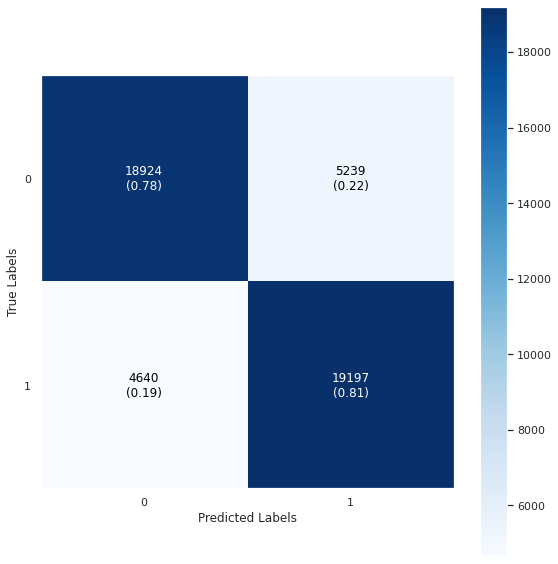

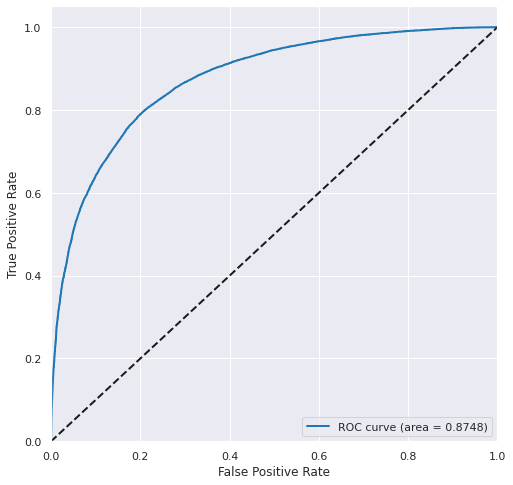

In [142]:
print("Accuracy Score on Test Set:")
# Inverse transform onehot labels using labelbinarizer
print(accuracy_score(y_test, y_pred_linear_svc))

# np.set_printoptions(precision=2)
# print(linear_svc_clf_final.classes_)
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_linear_svc, classes=xgb_clf_final.classes_)

# Plot ROC curve (requires onehot targets)
plot_roc_curve(y_test, y_score_linear_svc, classes=xgb_clf_final.classes_, roc_multilabel_count=2)

## LightGBM Classifier

In [1]:
# Linear support Vector Classification using one-vs-rest classification for multiclass learning
lgbm_clf = XGBClassifier()
lgbm_clf_fullpipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lgbm_classifier", lgbm_clf)
])
print(lgbm_clf_fullpipe)
print("")

NameError: name 'RandomForestClassifier' is not defined

In [138]:
# Specify hyperparameter grids for optimization

lgbm_param_grid = {
    "lgbm_classifier__n_estimators": [int(x) for x in np.linspace(50,550,11)],
    "lgbm_classifier__max_depth": max_depth,
    }

lgbm_param_grid.update(param_grid)

In [139]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {
    "LightGBM": (lgbm_clf_fullpipe, lgbm_param_grid),
}

### Train the gradient boosting pipeline model

In [140]:
lgbm_clf_final = pipeline_fit(
                                X_train=X_train,
                                y_train=y_train,
                                pipeline="LightGBM", 
                                search_method="gridsearch", 
#                                         n_iter=3,
                                verbose_searchcv=2, 
                                n_jobs=12, 
                                save_name="Twitter_test"
                            )

A joblib model file already exists with that name, 
do you wish to retrain the model? (Y/N) y


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('tweet_transformer',
                                                  Pipeline(memory=None,
                                                           steps=[('cleaner',
                                                                   Tweet_cleaner(verbose=False,
                                                                                 word2vec=False)),
                                                                  ('tfidf_vectorizer',
                                                                   TfidfVectorizer(analyzer='word',
                                                                                   binary=False,
                                                             

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:   19.5s
[Parallel(n_jobs=12)]: Done 150 out of 150 | elapsed:  1.8min finished


Preprocessing...
Preprocess Complete
(112000, 15000)

Linear_SVC:
Best Score:  0.7933214285714286
Best Params:  {'linear_svc_classifier__C': 0.1767766952966369, 'linear_svc_classifier__penalty': 'l2', 'preprocessor__tweet_transformer__tfidf_vectorizer__binary': True, 'preprocessor__tweet_transformer__tfidf_vectorizer__max_features': 15000, 'preprocessor__tweet_transformer__tfidf_vectorizer__ngram_range': (1, 2), 'preprocessor__tweet_transformer__tfidf_vectorizer__token_pattern': "(?u)\\b\\w\\w+\\b|\\'"}


### Evaluation

In [141]:
y_pred_linear_svc = lgbm_clf_final.predict(X_test)
y_score_linear_svc = lgbm_clf_final.decision_function(X_test)

Preprocessing...
Preprocess Complete
(48000, 15000)
Preprocessing...
Preprocess Complete
(48000, 15000)


Accuracy Score on Test Set:
0.7941875


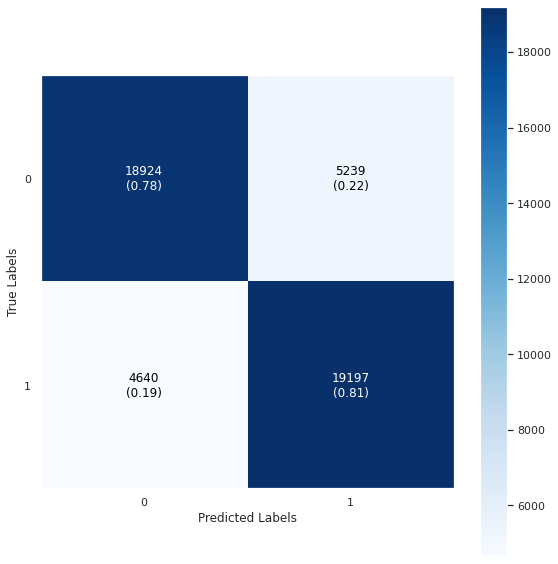

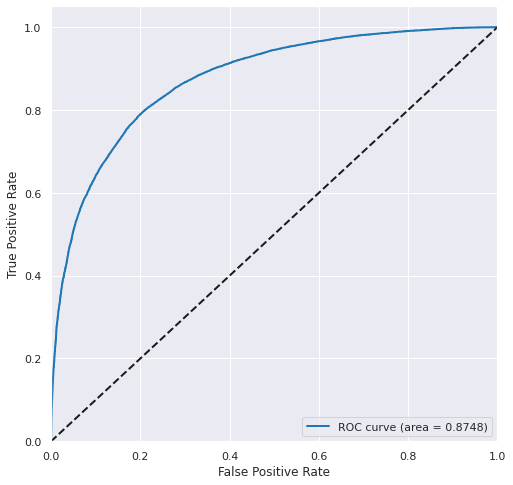

In [142]:
print("Accuracy Score on Test Set:")
# Inverse transform onehot labels using labelbinarizer
print(accuracy_score(y_test, y_pred_linear_svc))

# np.set_printoptions(precision=2)
# print(linear_svc_clf_final.classes_)
# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_linear_svc, classes=lgbm_clf_final.classes_)

# Plot ROC curve (requires onehot targets)
plot_roc_curve(y_test, y_score_linear_svc, classes=lgbm_clf_final.classes_, roc_multilabel_count=2)

# Neural Networks

## Tokenizer and embedding pipeline transformer

In [16]:
## Keras tokenizing function and optional word2vec embedding transformer
class Keras_tokenizer_embedding_transfomer(BaseEstimator, TransformerMixin):
    
    def __init__(self, verbose=False, word2vec=None, text_col=None, max_words=None, max_seq_len=None, vector_size=None):
        self.verbose = verbose
        self.word2vec = word2vec
        self.text_col = text_col
        self.max_words = max_words
        self.max_seq_len = max_seq_len
        self.vector_size = vector_size
        
    def fit(self, X, y=None):
        if(self.verbose):
            print("Verbose mode on!")
        return self
    
    
#     def preprocess_text(self, text: Union[Iterable, str]) -> List[str]:
# #         """ Prepare text for the model, excluding unknown words"""
# #         if not isinstance(raw_text, list):
# #             if not isinstance(raw_text, str):
# #                 raise TypeError(
# #                     f"Input should be a str or a list of str, got {type(raw_text)}"
# #                 )
# #             raw_tokens = raw_text.split()
#         for token in text:
#             return list(filter(lambda x: x in self.word2vec.vocab, token))
    
    
    
    ## Slight modification of zeugma source code
    def transform_text(self, text: Union[Iterable, str]) -> np.array:
        """ Compute an aggregate embedding vector for an input str or iterable of str.
        """
#         tokens = self.preprocess_text(text)
        embedding = []
        for token in text:
#             print(token)
            try:
                embedding.append(self.word2vec[token])
            except: 
                embedding.append(np.zeros(self.vector_size, dtype=np.float32))
        
        return embedding

#         if not tokens:
#             return np.zeros(self.vector_size, dtype=np.float32)

#         return self.word2vec[tokens]
    
    
    
    def transform(self, X, y=None):
        X = X["Tweet"].values
        self.text_count = len(X)
        #display(X)
        ## Use Keras tokenizer and padding for neural net inputs        
        if self.word2vec is not None:
            print("Transforming texts...")
            print(X.shape)
            
#             print(X[:5])
            
            X = [list(text.split()) for text in X]
#             print(X[:5])

            X = pad_sequences(X, maxlen=self.max_seq_len, padding="post", truncating="post", value=" ", dtype=object)
            print(X[:5])
            
            ## Conversion to word vectors, modification of Zeugma
            X = np.reshape([self.transform_text(text) for text in X], (self.text_count, self.max_seq_len, self.vector_size))
#             print(embeddings[0])
#             print(embeddings.shape)
            
            ## Pad each text array to the same length (post), a modification of keras pad_sequences
#             num_samples = len(embeddings)
#             lengths = []
#             sample_shape = ()
#             flag = True
            
#             for text in embeddings:
#                 try:
#                     lengths.append(len(embeddings))
#                     if flag and len(embeddings):
#                         sample_shape = np.asarray(embeddings).shape[1:]
#                         flag = False
#                 except TypeError:
#                     raise ValueError('`sequences` must be a list of iterables. '
#                                      'Found non-iterable: ' + str(embeddings))

#             embeddings = np.full((num_samples, self.vector_size) + sample_shape, np.zeros(self.vector_size,))
            
#             for idx, s in enumerate(embeddings):
#                 trunc = s[:self.vector_size]
                
#                 # check `trunc` has expected shape
#                 trunc = np.asarray(trunc)
#                 if trunc.shape[1:] != sample_shape:
#                     raise ValueError('Shape of sample %s of sequence at position %s '
#                                      'is different from expected shape %s' %
#                                      (trunc.shape[1:], idx, sample_shape))
#                 embeddings[idx, :len(trunc)] = trunc 
            
#             print(embeddings[:5])
            
#             print(embeddings.shape)
            print("Texts transformed")
            
            ## Stack arrays into large three-dimensional array
#             X = np.vstack(embeddings)
#             del embeddings
            
            print("Shape of transformed text data:", X.shape)
            print(X[0])
            print(X[0].shape)
            
        else:
            print("Tokenizing...")
    #         X = X[self.text_col].to_numpy()
            tokenizer = Tokenizer(num_words=self.max_words)
            tokenizer.fit_on_texts(X)

            sequences = tokenizer.texts_to_sequences(X)
            word_index = tokenizer.word_index
            print("%s unique tokens" % len(word_index))

            X = pad_sequences(sequences, maxlen=self.max_seq_len)
            print("Shape of tokenized text data:", X.shape)
            print("Tokenization Complete")
            
            
#             print("Preparing embedding matrix...")
            
#             nb_words = min(max_words, len(word_index))+1

#             embedding_matrix = np.zeros((nb_words, embedding_dim))
#             for word, i in word_index.items():
#                 if word in word2vec.vocab:
#                     embedding_matrix[i] = word2vec.word_vec(word)
#             print("Null word embeddings: %d" % np.sum(np.sum(embedding_matrix, axis=1) == 0))
#             print("Embedding matrix formation complete")
            
            

        return X

## Get pretrained word vectors and set param grid

In [15]:
## Load word vectors
while "word2vec" in globals():
    # Check if word2vec model is already loaded, ask user for confirmation of overwrite
    skip = input('''A word2vec model is already loaded, 
do you reload the model? (Y/N)''')
    if skip.lower().strip() == "y":
        print("Loading word2vec model...")
        word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
        print(type(word2vec))
        print("Found %s word vectors of word2vec" % len(word2vec.vocab))
    elif skip.lower().strip() == "n":
        print(type(word2vec))
        print("Found %s word vectors of word2vec" % len(word2vec.vocab))
        break
else:
    print("Loading word2vec model...")
    word2vec = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
    print(type(word2vec))
    print("Found %s word vectors of word2vec" % len(word2vec.vocab))

Loading word2vec model...
<class 'gensim.models.keyedvectors.Word2VecKeyedVectors'>
Found 3000000 word vectors of word2vec


In [16]:
## Get the length of a word vector
vector_size = word2vec.vector_size
print(vector_size)
# len(word2vec["computer"])

300


In [17]:
max_seq_len = 30
max_words = None

tweet_transformer_keras = Pipeline(steps=[
#    ("cleaner", Tweet_cleaner(word2vec=word2vec)),
#    ("keras_tokenizer", Keras_tokenizer(max_seq_len=max_seq_len)),
   ("keras_tokenizer_embedding_transfomer", Keras_tokenizer_embedding_transfomer(word2vec=word2vec, max_words=max_words, max_seq_len=max_seq_len, vector_size=vector_size))
   ])

preprocessor_keras = ColumnTransformer(
   transformers=[
       ("tweet_transformer_keras", tweet_transformer_keras, tweet_col)
       ])

## Keras Dense Neural Network

In [18]:
## Set callbacks for Keras model
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=15)

## Keras sklearn pipeline wrapper, dense layers require row major arrays
def create_dense_keras(input_shape=(max_seq_len,vector_size,),n_nodes_1=50,n_nodes_2=10,dropout=0.7,output_size=1,loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"],callbacks=[es]):
    
    print("-"*32)
    print("create_dense_fn called with:")
    print("\tInput Shape:", input_shape)
    print("\tDropout:", dropout)
    print("\tOutput Size:", output_size)
    print("\tLoss:", loss)
    print("\tOptimizer:", optimizer)
    print("\tMetrics:", metrics)
    print("\tCallbacks:", callbacks)
    print("-"*32)

    model = Sequential()

    model.add(layers.Dense(n_nodes_1, input_shape=input_shape, activation="relu"))
    model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(n_nodes_2, activation="relu"))
#     model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(output_size, activation="sigmoid"))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    print(model.summary())
    return model

In [19]:
# Dense neural net classification
dense_keras_clf = KerasClassifier(build_fn=create_dense_keras, verbose=1, batch_size=128, epochs=450) # wrap the model

# Specify Keras callbacks for early stopping and checkpoints
# calls = [ModelCheckpoint(, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")]
    
dense_keras_clf_fullpipe = Pipeline(steps=[
    ("preprocessor", tweet_transformer_keras),#preprocessor_keras),
    ("debug", Debug()),
    ("keras_estimator", dense_keras_clf)
])
print(dense_keras_clf_fullpipe)
print("")

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('keras_tokenizer_embedding_transfomer',
                                  Keras_tokenizer_embedding_transfomer(max_seq_len=30,
                                                                       max_words=None,
                                                                       text_col=None,
                                                                       vector_size=300,
                                                                       verbose=False,
                                                                       word2vec=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x7f2a9ba77a00>))],
                          verbose=False)),
                ('debug', Debug(verbose=False)),
                ('keras_estimator',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f29a180e2b0>)],
  

In [20]:
# Specify hyperparameter grids for optimization
dense_keras_param_grid = {
#     "keras_estimator__optimizer":["adam"],#["rmsprop","adam","adagrad"],
    "keras_estimator__epochs":[10,20,45,60],
    "keras_estimator__n_nodes_1":[5,10,20,50],
    "keras_estimator__n_nodes_2":[5,10,20,50],
#     "keras_estimator__dropout":[0.4,0.55,0.7]
#     "keras_estimator_input_shape":[(dense_keras_clf_fullpipe.named_steps["debug"].shape[1],)]
}

dense_keras_param_grid.update(param_grid)

In [21]:
# Dictionary of pipelines and classifier types for ease of reference
try:
    pipe_dict["Dense_Keras"] = (dense_keras_clf_fullpipe, dense_keras_param_grid)   
except NameError:
    pipe_dict = {
    "Dense_Keras": (dense_keras_clf_fullpipe, dense_keras_param_grid),
    }

### Train the dense neural network pipeline model

In [22]:
dense_keras_clf_final = pipeline_fit(
                                        X_train=X_train,
                                        y_train=y_train.reshape(-1,1),
                                        pipeline="Dense_Keras", 
                                        search_method=None,#"gridsearch",
                                        keras_nn=True,
                                        n_jobs=1,
                                        verbose_searchcv=1,  
                                        save_name="Twitter_test"
                                    )

A joblib model file already exists with that name, 
do you wish to retrain the model? (Y/N) y


No hyperparameter optimization
Training Dense_Keras on 112000 samples...
('keras_estimator', <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f29a180e2b0>)
Transforming texts...
(112000,)
[['looks' 'like' "tonight's" 'a' 'bit' 'of' 'a' 'bust' ' ' ' ' ' ' ' '
  ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['you' 'betcha' 'jack' 'wp' 'is' 'easy' 'peasy' 'stuff' 'for' 'me'
  'thinking' 'some' 'videos' 'are' 'in' 'order' ' ' ' ' ' ' ' ' ' ' ' '
  ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ']
 ['twit' 'help' 'how' 'do' 'i' 'remove' 'twitter' 'column' 'from' 'tweet'
  'deck' 'i' 'set' 'it' 'to' 'stay' 'signed' 'in' "it's" 'not' 'budging'
  'and' 'i' 'dont' 'want' 'it' 'there' 'anymore' ' ' ' ']
 ['i' 'have' 'waited' 'for' 'the' 'right' 'opportunity' 'to' 'think'
  'about' 'renting' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '
  ' ' ' ' ' ' ' ' ' ' ' ']
 ['something' 'good' 'come' 'on' 'tv' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' ' '
  ' ' ' ' ' ' ' '

KeyboardInterrupt: 

### Evaluation

In [160]:
# dense_keras_clf_final.named_steps["keras_estimator"].model = load_model(save_name+"_"+pipeline+".h5")

y_pred_dense_keras = dense_keras_clf_final.predict(X_test)
y_score_dense_keras = dense_keras_clf_final.predict_proba(X_test)

Transforming texts...
(48000, 1)
(48000, 300)
Texts transformed
[[ 0.01555786 -0.02466634  0.02034505 ...  0.02466838  0.04528809
   0.00822347]
 [ 0.0218099   0.02864583 -0.04223633 ... -0.01538086  0.04268392
   0.16015625]
 [ 0.00355632  0.03190613  0.08956706 ...  0.05293986  0.09660237
  -0.05838216]
 ...
 [ 0.08794556 -0.10411377  0.03192139 ... -0.0305542   0.00362549
   0.08238526]
 [-0.11132812  0.02734375 -0.11791992 ...  0.08056641  0.16333008
  -0.02471924]
 [-0.04793294  0.06526693  0.03401693 ...  0.12399292  0.24916585
  -0.04378255]]
Shape of transformed text data: (48000, 100)
(48000, 100)
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


375/375 [==============================] - 0s 328us/step
Transforming texts...
(48000, 1)
(48000, 300)
Texts transformed
[[ 0.01555786 -0.02466634  0.02034505 ...  0.02466838  0.04528809
   0.00822347]
 [ 0.0218099   0.02864583 -0.04223633 ... -0.01538086  0.04268392
   0.16015625]
 [ 0.00355632  0.03190613  0.08956706 ...  0.05293986  0.09660237
  -0.05838216]
 ...
 [ 0.08794556 -0.10411377  0.03192139 ... -0.0305542   0.00362549
   0.08238526]
 [-0.11132812  0.02734375 -0.11791992 ...  0.08056641  0.16333008
  -0.02471924]
 [-0.04793294  0.06526693  0.03401693 ...  0.12399292  0.24916585
  -0.04378255]]
Shape of transformed text data: (48000, 100)
(48000, 100)
Instructions for updating:
Please use `model.predict()` instead.


Instructions for updating:
Please use `model.predict()` instead.


375/375 [==============================] - 0s 313us/step


Accuracy Score on Test Set:
0.7228958333333333


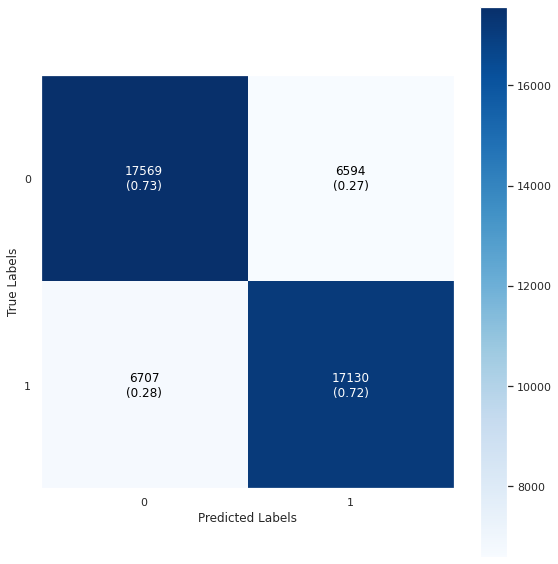

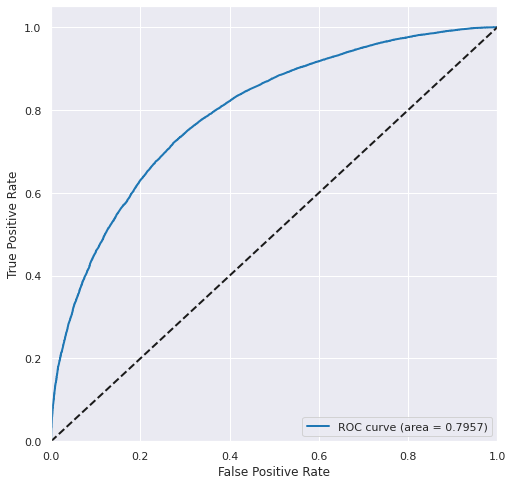

In [161]:
print("Accuracy Score on Test Set:")
print(accuracy_score(y_test, y_pred_dense_keras))

# np.set_printoptions(precision=2)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_dense_keras, classes=dense_keras_clf_final.classes_)

# Plot ROC curve (requires onehot targets)
plot_roc_curve(y_test, y_score_dense_keras[:,1], classes=dense_keras_clf_final.classes_, roc_multilabel_count=2)

## Keras LSTM Neural Network

In [ ]:
# weight_val = np.ones(len(labels_val))
# if re_weight:
#     weight_val *= 0.472001959
#     weight_val[labels_val==0] = 1.309028344

# ########################################
# ## define the model structure
# ########################################

# MAX_SEQUENCE_LENGTH = 30
# MAX_NB_WORDS = 200000
# EMBEDDING_DIM = 300
# VALIDATION_SPLIT = 0.1

# num_lstm = np.random.randint(175, 275)
# num_dense = np.random.randint(100, 150)
# rate_drop_lstm = 0.15 + np.random.rand() * 0.25
# rate_drop_dense = 0.15 + np.random.rand() * 0.25

# re_weight = True # whether to re-weight classes to fit the 17.5% share in test set

# STAMP = 'lstm_%d_%d_%.2f_%.2f'%(num_lstm, num_dense, rate_drop_lstm, \
#         rate_drop_dense)


# embedding_layer = Embedding(nb_words,
#         EMBEDDING_DIM,
#         weights=[embedding_matrix],
#         input_length=MAX_SEQUENCE_LENGTH,
#         trainable=False)
# lstm_layer = LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm)

# sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedded_sequences_1 = embedding_layer(sequence_1_input)
# x1 = lstm_layer(embedded_sequences_1)

# sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# embedded_sequences_2 = embedding_layer(sequence_2_input)
# y1 = lstm_layer(embedded_sequences_2)

# merged = concatenate([x1, y1])
# merged = Dropout(rate_drop_dense)(merged)
# merged = BatchNormalization()(merged)

# merged = Dense(num_dense, activation=act)(merged)
# merged = Dropout(rate_drop_dense)(merged)
# merged = BatchNormalization()(merged)

# preds = Dense(1, activation='sigmoid')(merged)

# ########################################
# ## add class weight
# ########################################
# if re_weight:
#     class_weight = {0: 1.309028344, 1: 0.472001959}
# else:
#     class_weight = None

# ########################################
# ## train the model
# ########################################
# model = Model(inputs=[sequence_1_input, sequence_2_input], \
#         outputs=preds)
# model.compile(loss='binary_crossentropy',
#         optimizer='nadam',
#         metrics=['acc'])
# #model.summary()
# print(STAMP)

# early_stopping =EarlyStopping(monitor='val_loss', patience=3)
# bst_model_path = STAMP + '.h5'
# model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

# hist = model.fit([data_1_train, data_2_train], labels_train, \
#         validation_data=([data_1_val, data_2_val], labels_val, weight_val), \
#         epochs=200, batch_size=2048, shuffle=True, \
#         class_weight=class_weight, callbacks=[early_stopping, model_checkpoint])

# model.load_weights(bst_model_path)
# bst_val_score = min(hist.history['val_loss'])

In [34]:
## Set callbacks for Keras model
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=5)

## Keras sklearn pipeline wrapper, dense layers require row major arrays
def create_lstm_keras(input_shape=(max_seq_len,vector_size,),output_size=1,dropout=0.7,loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"],callbacks=[es]):

    model = Sequential()
    
    model.add(layers.LSTM(50, input_shape=input_shape, activation="relu"))
#     model.add(layers.Dropout(rate=dropout))
#     model.add(layers.(10, activation="relu"))
#     model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(output_size, activation="sigmoid"))
    
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)

    return model

In [39]:
# Dense neural net classification
lstm_keras_clf = KerasClassifier(build_fn=create_lstm_keras, verbose=1, batch_size=128, epochs=20) # wrap the model

# Specify Keras callbacks for early stopping and checkpoints
# calls = [ModelCheckpoint(, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")]
    
lstm_keras_clf_fullpipe = Pipeline(steps=[
    ("preprocessor", tweet_transformer_keras),#preprocessor_keras),
#     ("debug", Debug()),
    ("keras_estimator", lstm_keras_clf)
])
print(lstm_keras_clf_fullpipe)
print("")

Pipeline(memory=None,
         steps=[('preprocessor',
                 Pipeline(memory=None,
                          steps=[('keras_tokenizer_embedding_transfomer',
                                  Keras_tokenizer_embedding_transfomer(max_seq_len=30,
                                                                       max_words=None,
                                                                       text_col=None,
                                                                       vector_size=300,
                                                                       verbose=False,
                                                                       word2vec=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x7f6537a0e7f0>))],
                          verbose=False)),
                ('keras_estimator',
                 <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f602c9d6250>)],
         verbose=False)



In [40]:
# Specify hyperparameter grids for optimization
lstm_keras_param_grid = {
    "keras_estimator__optimizer":["adam"],#["rmsprop","adam","adagrad"],
    "keras_estimator__epochs":[10,20,45,60],
    "keras_estimator__dropout":[0.4,0.55,0.7]
}

lstm_keras_param_grid.update(param_grid)

In [41]:
# Dictionary of pipelines and classifier types for ease of reference
try:
    pipe_dict["LSTM_Keras"] = (lstm_keras_clf_fullpipe, lstm_keras_param_grid)   
except NameError:
    pipe_dict = {
    "LSTM_Keras": (lstm_keras_clf_fullpipe, lstm_keras_param_grid),
    }

### Train the LSTM neural network pipeline model

In [42]:
lstm_keras_clf_final = pipeline_fit(
                                        X_train=X_train,
                                        y_train=y_train,
                                        pipeline="LSTM_Keras", 
                                        search_method=None,#"gridsearch",
                                        keras_nn=True,
                                        n_jobs=6,
                                        verbose_searchcv=1,  
                                        save_name="Twitter_LSTM"
                                    )

No hyperparameter optimization
Training LSTM_Keras on 112000 samples...
('keras_estimator', <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f602c9d6250>)
Transforming texts...
(112000,)
Texts transformed
Shape of transformed text data: (112000, 30, 300)
[[ 0.02404785  0.31445312 -0.02624512 ...  0.01525879  0.06494141
   0.14257812]
 [ 0.10351562  0.13769531 -0.00297546 ...  0.04394531 -0.14550781
   0.07128906]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Epoch 1/20
875/875 [==============================] - 15s 17ms/step - loss: 0.5395 - accuracy: 0.7204
Epoch 2/20
875/875 [==============================] - 14s 16ms/step - loss: 0.4525 - accuracy: 0.7897
Epoch 3/20
875/875 [==============================] - 

### Evaluation

In [43]:
# dense_keras_clf_final.named_steps["keras_estimator"].model = load_model(save_name+"_"+pipeline+".h5")

y_pred_lstm_keras = lstm_keras_clf_final.predict(X_test)
y_score_lstm_keras = lstm_keras_clf_final.predict_proba(X_test)

Transforming texts...
(48000,)
Texts transformed
Shape of transformed text data: (48000, 30, 300)
[[-0.47851562 -0.23242188 -0.14746094 ... -0.07763672 -0.23242188
   0.1875    ]
 [ 0.00704956 -0.07324219  0.171875   ...  0.01123047  0.1640625
   0.10693359]
 [ 0.06298828  0.18457031 -0.04760742 ...  0.13671875  0.16894531
  -0.10009766]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


375/375 [==============================] - 3s 7ms/step
Transforming texts...
(48000,)
Texts transformed
Shape of transformed text data: (48000, 30, 300)
[[-0.47851562 -0.23242188 -0.14746094 ... -0.07763672 -0.23242188
   0.1875    ]
 [ 0.00704956 -0.07324219  0.171875   ...  0.01123047  0.1640625
   0.10693359]
 [ 0.06298828  0.18457031 -0.04760742 ...  0.13671875  0.16894531
  -0.10009766]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Instructions for updating:
Please use `model.predict()` instead.


Instructions for updating:
Please use `model.predict()` instead.


375/375 [==============================] - 3s 7ms/step


Accuracy Score on Test Set:
0.791


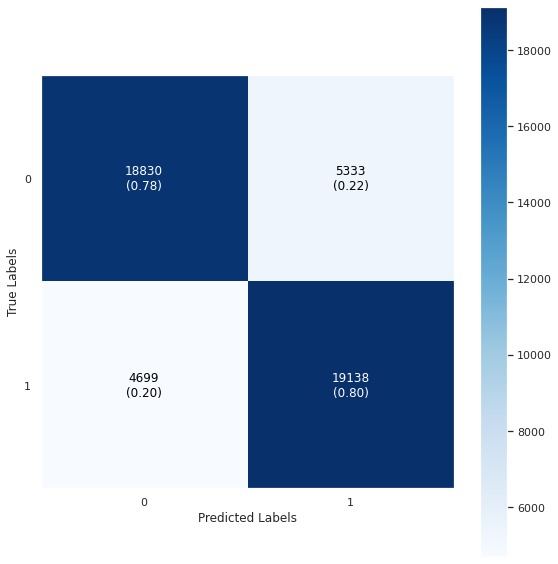

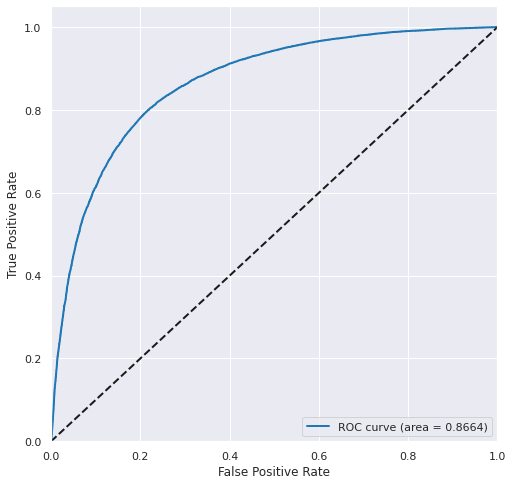

In [45]:
print("Accuracy Score on Test Set:")
print(accuracy_score(y_test, y_pred_lstm_keras))

# np.set_printoptions(precision=2)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_lstm_keras, classes=lstm_keras_clf_final.classes_)

# Plot ROC curve (requires onehot targets)Q
plot_roc_curve(y_test, y_score_lstm_keras[:,1], classes=lstm_keras_clf_final.classes_, roc_multilabel_count=2)

## SimpleTransformer ROBERTA Neural Network

### Preprocessing and Custom Sklearn Estimator

In [19]:
class RobertaClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, overwrite_output_dir=False, epochs=2, train_batch_size=6):#, best_model_dir=None, cache_dir=None, 
#                  num_workers=None, early_stopping_delta=None, early_stopping_patience=None,
#                  learning_rate=None, manual_seed=None, max_seq_length=None, output_dir=None,
#                  train_batch_size=None, use_early_stopping=None, weight_decay=None):
        
#         self.verbose = verbose
        self.overwrite_output_dir = overwrite_output_dir
#         self.adam_epsilon = adam_epsilon
        self.num_train_epochs = epochs
#         self.best_model_dir = best_model_dir
#         self.cache_dir = cache_dir
#         self.dataloader_num_workers = dataloader_num_workers
#         self.early_stopping_delta = early_stopping_delta
#         self.early_stopping_patience = early_stopping_patience
#         self.learning_rate = learning_rate
#         self.manual_seed = manual_seed
#         self.max_seq_length = max_seq_length
#         self.output_dir = output_dir
        self.train_batch_size = train_batch_size
#         self.use_early_stopping = use_early_stopping
#         self.weight_decay = weight_decay
    
#     def get_params(self, deep=True):

#         return {"adam_epsilon": self.adam_epsilon, 
#                 "epochs": self.num_train_epochs, 
#                 "best_model_dir": self.best_model_dir,
#                 "cache_dir": self.cache_dir,
#                 "num_workers": self.dataloader_num_workers,
#                 "early_stopping_delta": self.early_stopping_delta,
#                 "early_stopping_patience": self.early_stopping_patience,
#                 "learning_rate": self.learning_rate,
#                 "manual_seed": self.manual_seed,
#                 "max_seq_length": self.max_seq_length,
#                 "output_dir": self.output_dir,
#                 "train_batch_size": self.train_batch_size,
#                 "use_early_stopping": self.use_early_stopping,
#                 "weight_decay": self.weight_decay
#                }
    
#         """
#             adam_epsilon	float	1e-8	Epsilon hyperparameter used in AdamOptimizer.
#             best_model_dir	str	outputs/best_model	The directory where the best model (model checkpoints) will be saved (based on eval_during_training)
#             cache_dir	str	cache_dir	The directory where cached files will be saved.
#             config	dict	{}	A dictionary containing configuration options that should be overriden in a model’s config.
#             dataloader_num_workers	int	cpu_count () - 2 if cpu_count () > 2 else 1	Number of worker processed to use with the Pytorch dataloader.
#             do_lower_case	bool	False	Set to True when using uncased models.
#             dynamic_quantize	bool	False	Set to True to use dynamic quantization.
#             early_stopping_consider_epochs	bool	False	If True, end of epoch evaluation score will be considered for early stopping.
#             early_stopping_delta	float	0	The improvement over best_eval_loss necessary to count as a better checkpoint.
#             early_stopping_metric	str	eval_loss	The metric that should be used with early stopping. (Should be computed during eval_during_training).
#             early_stopping_metric_minimize	bool	True	Whether early_stopping_metric should be minimized (or maximized).
#             early_stopping_patience	int	3	Terminate training after this many evaluations without an improvement in the evaluation metric greater then early_stopping_delta.
#             encoding	str	None	Specify an encoding to be used when reading text files.
#             eval_batch_size	int	8	The evaluation batch size.
#             evaluate_during_training	bool	False	Set to True to perform evaluation while training models. Make sure eval data is passed to the training method if enabled.
#             evaluate_during_training_steps	int	2000	Perform evaluation at every specified number of steps. A checkpoint model and the evaluation results will be saved.
#             evaluate_during_training_verbose	bool	False	Print results from evaluation during training.
#             fp16	bool	True	Whether or not fp16 mode should be used. Requires NVidia Apex library.
#             gradient_accumulation_steps	int	1	The number of training steps to execute before performing a optimizer.step(). Effectively increases the training batch size while sacrificing training time to lower memory consumption.
#             learning_rate	float	4e-5	The learning rate for training.
#             logging_steps	int	50	Log training loss and learning at every specified number of steps.
#             manual_seed	int	None	Set a manual seed if necessary for reproducible results.
#             max_grad_norm	float	1.0	Maximum gradient clipping.
#             max_seq_length	int	128	Maximum sequence length the model will support.
#             multiprocessing_chunksize	int	500	Number of examples sent to a CPU core at a time when using multiprocessing. Usually, the optimal value will be (roughly) number of examples / process count.
#             n_gpu	int	1	Number of GPUs to use.
#             no_cache	bool	False	Cache features to disk.
#             no_save	bool	False	If True, models will not be saved to disk.
#             num_train_epochs	int	1	The number of epochs the model will be trained for.
#             output_dir	str	“outputs/”	The directory where all outputs will be stored. This includes model checkpoints and evaluation results.
#             overwrite_output_dir	bool	False	If True, the trained model will be saved to the ouput_dir and will overwrite existing saved models in the same directory.
#             process_count	int	cpu_count () - 2 if cpu_count () > 2 else 1	Number of cpu cores (processes) to use when converting examples to features. Default is (number of cores - 2) or 1 if (number of cores <= 2)
#             quantized_model	bool	False	Set to True if loading a quantized model. Note that this will automatically be set to True if dynamic_quantize is enabled.
#             reprocess_input_data	bool	True	If True, the input data will be reprocessed even if a cached file of the input data exists in the cache_dir.
#             save_eval_checkpoints	bool	True	Save a model checkpoint for every evaluation performed.
#             save_model_every_epoch	bool	True	Save a model checkpoint at the end of every epoch.
#             save_steps	int	2000	Save a model checkpoint at every specified number of steps.
#             save_optimizer_and_scheduler	bool	True	Save optimizer and scheduler whenever they are available.
#             silent	bool	False	Disables progress bars.
#             tensorboard_dir	str	None	The directory where Tensorboard events will be stored during training. By default, Tensorboard events will be saved in a subfolder inside runs/ like runs/Dec02_09-32-58_36d9e58955b0/.
#             train_batch_size	int	8	The training batch size.
#             use_cached_eval_features	bool	False	Evaluation during training uses cached features. Setting this to False will cause features to be recomputed at every evaluation step.
#             use_early_stopping	bool	False	Use early stopping to stop training when early_stopping_metric doesn’t improve (based on early_stopping_patience, and early_stopping_delta)
#             use_multiprocessing	bool	True	If True, multiprocessing will be used when converting data into features. Disabling can reduce memory usage, but may substantially slow down processing.
#             wandb_kwargs	dict	{}	Dictionary of keyword arguments to be passed to the W&B project.
#             wandb_project	str	None	Name of W&B project. This will log all hyperparameter values, training losses, and evaluation metrics to the given project.
#             warmup_ratio	float	0.06	Ratio of total training steps where learning rate will “warm up”. Overridden if warmup_steps is specified.
#             warmup_steps	int	0	Number of training steps where learning rate will “warm up”. Overrides warmup_ratio.
#             weight_decay	int	0	Adds L2 penalty.

#         """

#     def set_params(self, **parameters):
#         for parameter, value in parameters.items():
#             setattr(self, parameter, value)
#         return self
        
        
    def fit(self, X, y): 
        
        # Check that X and y have correct shape
#         X, y = check_X_y(X, y)
        # Store the classes seen during fit
#         self.classes_ = unique_labels(y)
        
        df = X.rename(columns={"Tweet":"text"})
        df["label"] = y
#         display(df)
        
        self.df_ = df
        
        # Optional model configuration
        model_args = ClassificationArgs()
        model_args.overwrite_output_dir = self.overwrite_output_dir
#         model_args.adam_epsilon = self.adam_epsilon
        model_args.num_train_epochs = self.num_train_epochs
#         model_args.best_model_dir = self.best_model_dir
#         model_args.cache_dir = self.cache_dir
#         model_args.dataloader_num_workers = self.dataloader_num_workers
#         model_args.early_stopping_delta = self.early_stopping_delta
#         model_args.early_stopping_patience = self.early_stopping_patience
#         model_args.learning_rate = self.learning_rate
#         model_args.manual_seed = self.manual_seed
#         model_args.max_seq_length = self.max_seq_length
#         model_args.output_dir = self.output_dir
        model_args.train_batch_size = self.train_batch_size
#         model_args.use_early_stopping = self.use_early_stopping
#         model_args.weight_decay = self.weight_decay
        
        print(model_args)
        # Create a ClassificationModel
        self.model = ClassificationModel(
            "distilbert", "distilbert-base-uncased", args=model_args, use_cuda=True
            #"roberta", "roberta-base", args=model_args, use_cuda=True
        )

        # Train the model
        self.model.train_model(self.df_)

        # Return the classifier
        return self
    
    

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
#         X = check_array(X)
        
        # Predictions
        y_pred, _ = self.model.predict(X)
        print(y_pred)
        
        return y_pred

In [19]:
prefix = 'Data/yelp_review_polarity_csv/'

train_df = pd.read_csv(prefix + 'train.csv', header=None)
train_df.head()

eval_df = pd.read_csv(prefix + 'test.csv', header=None)
eval_df.head()

train_df[0] = (train_df[0] == 2).astype(int)
eval_df[0] = (eval_df[0] == 2).astype(int)

train_df = pd.DataFrame({
    'text': train_df[1].replace(r'\n', ' ', regex=True),
    'label':train_df[0]
})

print(train_df.head())

eval_df = pd.DataFrame({
    'text': eval_df[1].replace(r'\n', ' ', regex=True),
    'label':eval_df[0]
})

print(eval_df.head())

In [20]:
display(train_df)

,text,label
0,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff. It seems that his staff simply never answers the phone. It usually takes 2 hours of repeated calling to get an answer. Who has time for that or wants to deal with it? I have run into this problem with many other doctors and I just don't get it. You have office workers, you have patients with medical needs, why isn't anyone answering the phone? It's incomprehensible and not work the aggravation. It's with regret that I feel that I have to give Dr. Goldberg 2 stars.",0
1,"Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life.",1
2,"I don't know what Dr. Goldberg was like before moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you call the office, they'll put you through to a voice mail, that NO ONE ever answers or returns your call. Both my adult children and husband have decided to leave this practice after experiencing such frustration. The entire office has an attitude like they are doing you a favor. Give me a break! Stay away from this doc and the practice. You deserve better and they will not be there when you really need them. I have never felt compelled to write a bad review about anyone until I met this pathetic excuse for a doctor who is all about the money.",0
3,"I'm writing this review to give you a heads up before you see this Doctor. The office staff and administration are very unprofessional. I left a message with multiple people regarding my bill, and no one ever called me back. I had to hound them to get an answer about my bill. \n\nSecond, and most important, make sure your insurance is going to cover Dr. Goldberg's visits and blood work. He recommended to me that I get a physical, and he knew I was a student because I told him. I got the physical done. Later, I found out my health insurance doesn't pay for preventative visits. I received an $800.00 bill for the blood work. I can't pay for my bill because I'm a student and don't have any cash flow at this current time. I can't believe the Doctor wouldn't give me a heads up to make sure my insurance would cover work that wasn't necessary and was strictly preventative. The office can't do anything to help me cover the bill. In addition, the office staff said the onus is on me to make sure my insurance covers visits. Frustrating situation!",0
4,"All the food is great here. But the best thing they have is their wings. Their wings are simply fantastic!! The \""Wet Cajun\"" are by the best & most popular. I also like the seasoned salt wings. Wing Night is Monday & Wednesday night, $0.75 whole wings!\n\nThe dining area is nice. Very family friendly! The bar is very nice is well. This place is truly a Yinzer's dream!! \""Pittsburgh Dad\"" would love this place n'at!!",1
...,...,...
559995,"Ryan was as good as everyone on yelp has claimed. He was courteous, knowledgable, and helpful. I had some issues with my irrigation and he fixed them all quick and made sure all of the o

In [21]:
# Create a TransformerModel
model = ClassificationModel('distilbert', 'distilbert-base-uncased', use_cuda=True)

model_args = {
    "train_batch_size": 64,
    "num_train_epochs": 5,
    "learning_rate": 1e-4,
    "overwrite_output_dir": True,
#     "wandb_project": "simpletransformers"
}

# Train the model
model.train_model(train_df[:100000], args=model_args)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

  0%|          | 0/100000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/1563 [00:00<?, ?it/s]

D:\Users\Michael\anaconda3\envs\ml_nlp\lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running Epoch 1 of 5:   0%|          | 0/1563 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/1563 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/1563 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/1563 [00:00<?, ?it/s]

(7815, 0.09738091828114097)

In [22]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df[:30000])
print(result)
# print(model_outputs)
# print(wrong_predictions)

D:\Users\Michael\anaconda3\envs\ml_nlp\lib\site-packages\simpletransformers\classification\classification_model.py:969: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/30000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/3750 [00:00<?, ?it/s]

{'mcc': 0.8546258588170861, 'tp': 13698, 'tn': 14121, 'fp': 1009, 'fn': 1172, 'eval_loss': 0.4246413547646094}


In [20]:
# Dense neural net classification
roberta_clf = RobertaClassifier(overwrite_output_dir=True, epochs=1, train_batch_size=32) # wrap the model

# Specify Keras callbacks for early stopping and checkpoints
# calls = [ModelCheckpoint(, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")]
    
roberta_clf_fullpipe = Pipeline(steps=[
    ("roberta_estimator", roberta_clf)
])
print(roberta_clf_fullpipe)
print("")

Pipeline(steps=[('roberta_estimator',
                 RobertaClassifier(epochs=None, overwrite_output_dir=True,
                                   train_batch_size=32))])



D:\Users\Michael\anaconda3\envs\ml_nlp\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


In [21]:
# Specify hyperparameter grids for optimization
roberta_param_grid = {
#    "roberta_estimator__epochs":[2]
}

roberta_param_grid.update(param_grid)

In [22]:
# Dictionary of pipelines and classifier types for ease of reference
try:
    pipe_dict["Roberta"] = (roberta_clf_fullpipe, roberta_param_grid)   
except NameError:
    pipe_dict = {
    "Roberta": (roberta_clf_fullpipe, roberta_param_grid),
    }

### Train the ROBERTA neural network pipeline model

In [23]:
roberta_clf_final = pipeline_fit(
                                        X_train=X_train[:100],
                                        y_train=y_train[:100],
                                        pipeline="Roberta", 
                                        search_method=None,#"gridsearch",
#                                         n_jobs=6,
                                        verbose_searchcv=1,  
                                        save_name="Twitter_Roberta"
                                    )

A joblib model file already exists with that name, 
do you wish to retrain the model? (Y/N) y


No hyperparameter optimization
Training Roberta on 100 samples...
('roberta_estimator', RobertaClassifier(epochs=None, overwrite_output_dir=True, train_batch_size=32))
ClassificationArgs(adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, adafactor_eps=(1e-30, 0.001), adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_beta1=None, adafactor_scale_parameter=True, adafactor_relative_step=True, adafactor_warmup_init=True, eval_batch_size=8, evaluate_during_training=False, evaluate_during_training_silent=True, evaluate_during_training_steps=2000, evaluate_during_training_verbose=False, evaluate_each_epoch=T

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/4 [00:00<?, ?it/s]

D:\Users\Michael\anaconda3\envs\ml_nlp\lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


### Evaluation

In [24]:
print(X_test["Tweet"].tolist()[0])

iphone is doing that not opening downloaded apps thing and i forgot my cord at home


In [25]:
# dense_keras_clf_final.named_steps["keras_estimator"].model = load_model(save_name+"_"+pipeline+".h5")


y_pred_roberta = roberta_clf_final.predict(X_test["Tweet"].tolist())
y_score_roberta = roberta_clf_final.predict_proba(X_test["Tweet"].tolist())

  0%|          | 0/48000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

[0 0 0 ... 0 0 0]


AttributeError: 'RobertaClassifier' object has no attribute 'predict_proba'

In [ ]:
print("Accuracy Score on Test Set:")
print(accuracy_score(y_test, y_pred_roberta))

# np.set_printoptions(precision=2)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_roberta, classes=roberta_clf_final.classes_)

# Plot ROC curve (requires onehot targets)Q
plot_roc_curve(y_test, y_score_roberta[:,1], classes=roberta_clf_final.classes_, roc_multilabel_count=2)

# Voting Classifier

In [ ]:
## Use a soft voting classifier to make final predictions from all models
vote_clf = VotingClassifier(estimators=[
                            ("nb_clf", nb_clf_final.named_steps["nb_classifier"]), 
                            ("rf_clf", rf_clf_final.named_steps["rf_classifier"]),
                            #("gb_clf", gb_clf_final), 
                            #("xgb_clf", xgb_clf_final),
                            ("lgbm_clf", lgbm_clf_final.named_steps["lgbm_classifier"])
                            ], voting="soft")

vote_clf_fullpipe = Pipeline(steps=[
                                ("preprocessor", preprocessor),
                                ("voting_classifier", vote_clf)
                            ])

print(vote_clf_fullpipe)


pipe_dict["VotingClassifier"] = (vote_clf_fullpipe,)

In [ ]:
vote_clf_final = pipeline_fit(pipeline="VotingClassifier", cv=None, iid=False, verbose=2, n_jobs=1, optimization=False)

In [ ]:
#display(X_valid)
y_pred = vote_clf_final.predict(X_valid)
#y_pred = lgbm_clf_final.predict(X_valid)
print("Predicted Targets:",y_pred)
print("Actual Targets:",y_valid)

In [ ]:
y_pred_2 = lgbm_clf_final.predict(X_valid_2)
print("Predicted Targets:",y_pred_2)
print("Actual Targets:",y_valid_2)

In [ ]:
#y_pred_inv = le.inverse_transform(y_pred)
target_names = le.classes_
print("Target names: ",target_names)
n_classes = le.classes_.shape[0]
print("n_classes: ",n_classes)
print("\nClassification Report:")
print(classification_report(y_valid, y_pred, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred, labels=range(n_classes)))

In [ ]:
target_names = le.classes_
print("Target names: ",target_names)
n_classes = le.classes_.shape[0]
print("n_classes: ",n_classes)
print("\nClassification Report:")
print(classification_report(y_valid_2, y_pred_2, target_names=target_names))
print("Confusion Matrix:")
print(confusion_matrix(y_valid_2, y_pred_2, labels=range(n_classes)))